In [2]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array_equal
from keras import models
from keras import Input
import keras.backend as K
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Flatten,Embedding
from keras.layers import Lambda, TimeDistributed

In [3]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # To force autocompletion

In [4]:
data_path  = '/content/sample_data/hin.txt'
with open(data_path, 'r', encoding = 'utf-8') as f:
    lines = f.read()

'Wow!\tवाह!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #6179147 (fastrizwaan)\nHelp!\t'

In [5]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [text[0:2] for text in [i.split('\t') for i in sents]]
    return sents

In [6]:
df = to_lines(lines)
df[:10]

[['Wow!', 'वाह!'],
 ['Help!', 'बचाओ!'],
 ['Jump.', 'उछलो.'],
 ['Jump.', 'कूदो.'],
 ['Jump.', 'छलांग.'],
 ['Hello!', 'नमस्ते।'],
 ['Hello!', 'नमस्कार।'],
 ['Cheers!', 'वाह-वाह!'],
 ['Cheers!', 'चियर्स!'],
 ['Got it?', 'समझे कि नहीं?']]

In [7]:
df = pd.DataFrame(df, columns = [ 'english', 'hindi'])
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,english,hindi
0,Cheers!,चियर्स!
1,I can swim.,मुझे तैरना आता है।
2,I'd rather not meet him.,हो सके तो मैं उससे मिलना नहीं चाहूँगी।
3,We often make mistakes.,हम अक्सर ग़लतियाँ कर बैठते हैं।
4,The king ordered that the prisoner should be s...,राजा ने हुक़्म दिया कि क़ैदी को रिहा कर दिया जाए।


In [8]:
df['english'] = df.english.apply(lambda x:x.lower())
df['hindi'] = df.hindi.apply(lambda x:x.lower())

In [ ]:
!pip install text_hammer
import text_hammer as th

In [10]:
import string
exclude = set(string.punctuation)
import re
df['english'] = df.english.apply(lambda x:re.sub("'",'',x))
df['hindi'] = df.hindi.apply(lambda x:re.sub("'",'',x))
df['english'] = df.english.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi'] = df.hindi.apply(lambda x: ''.join(ch for ch in x if ch not in exclude ))
df['english'] = df.english.apply(lambda x:re.sub('[0-9]+','',x))
df['hindi'] = df.hindi.apply(lambda x:re.sub('[0-9]+','',x))
df['hindi'] = df.hindi.apply(lambda x:re.sub('[२३०८१५७९४६]','',x))
df['english']=df['english'].apply(lambda x: x.strip())
df['hindi']=df['hindi'].apply(lambda x: x.strip())
df['english']=df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi']=df['hindi'].apply(lambda x: re.sub(" +", " ", x))
df['hindi'] = df.hindi.apply(lambda x: re.sub('[A-Za-z]+','',x))
df['english'] = df.english.progress_apply(lambda x:th.cont_exp(x))

  0%|          | 0/2779 [00:00<?, ?it/s]

In [11]:
df['hindi']= df['hindi'].apply(lambda x: 'START_ '+x+' _END')

In [12]:
df['hindi_len'] = df.hindi.apply(lambda x:len(x.split()))
df['english_len'] = df.english.apply(lambda x:len(x.split()))

22


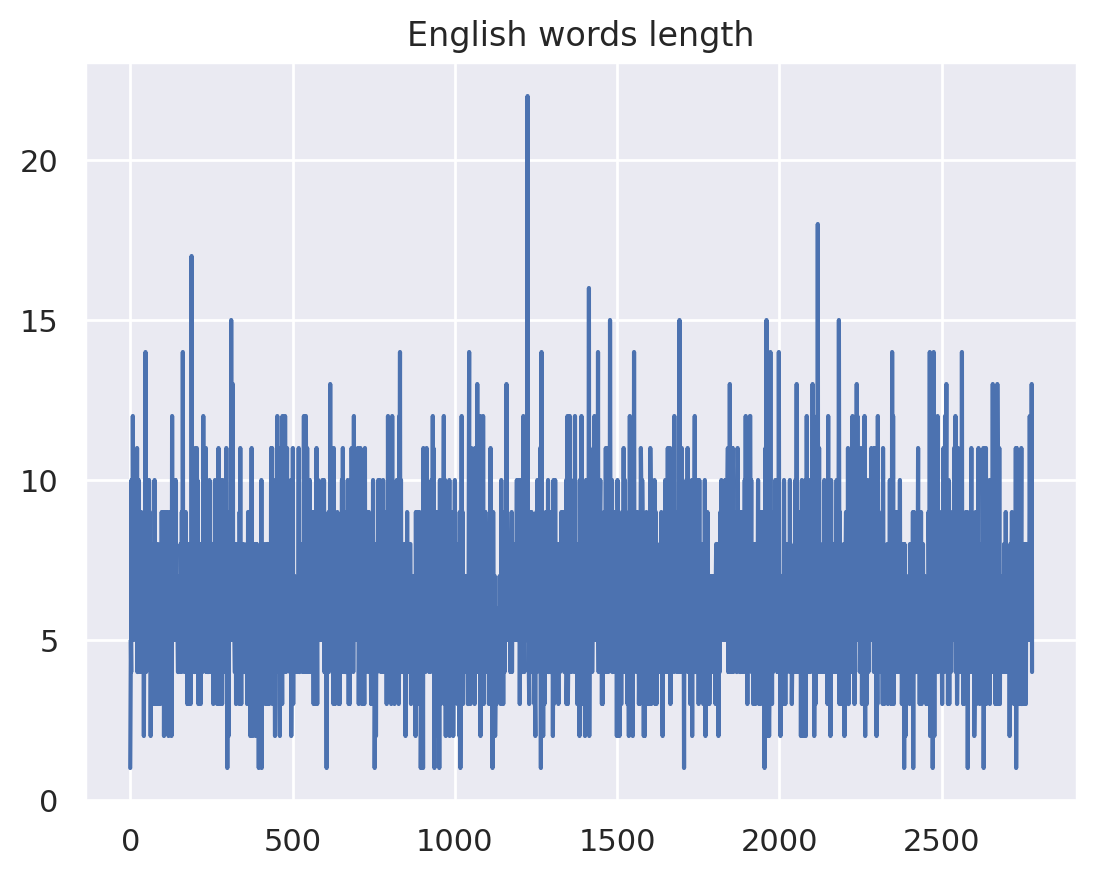

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
y = [len(x.split()) for x in df.english]
plt.plot(y)
plt.title('English words length')
print(np.max(y))

27


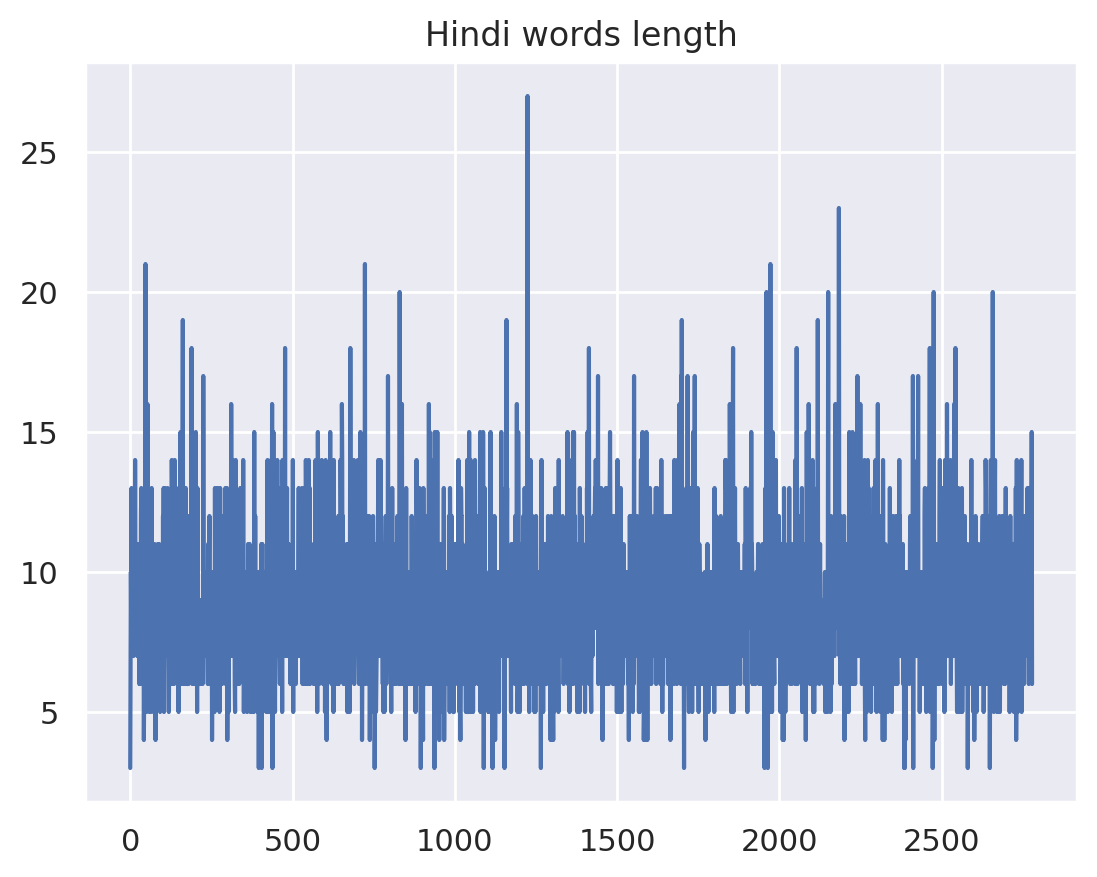

In [14]:
y = [len(x.split()) for x in df.hindi]
plt.plot(y)
plt.title('Hindi words length')
print(np.max(y))

In [15]:
df = df[(df.english_len<20)*(df.hindi_len<20)]

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.english, df.hindi, test_size = 0.1, random_state= 42)

In [19]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(df):
    tokenizer = Tokenizer(lower  = False, filters = '|!')
    tokenizer.fit_on_texts(df)
    return tokenizer

In [20]:
english_tokenizer = create_tokenizer(df.english)
hindi_tokenizer = create_tokenizer(df.hindi)

In [21]:
english_num_tokens = len(english_tokenizer.word_index) + 1
hindi_num_tokens= len(hindi_tokenizer.word_index) + 1
max_english_len = df.english_len.max()
max_hindi_len = df.hindi_len.max()

In [22]:
hindi_num_tokens

2961

In [23]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_english_len),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_hindi_len),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_hindi_len,hindi_num_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = english_tokenizer.word_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = hindi_tokenizer.word_index[word] # decoder input seq
                    if t>0: # here we will skip _START
                        # decoder target sequence (one hot encoded) because it will be compared to the prediction
                        # does not include the START_ token
                        # Offset by one timestep because we are not going to include the START_
                        decoder_target_data[i, t - 1, hindi_tokenizer.word_index[word]] = 1 # this is 3D
            yield([encoder_input_data, decoder_input_data], decoder_target_data)
            # decoder target data wiill be used to force our decoder to find right training

In [56]:
latent_dim = 512

encoder_inputs= Input(shape=(None,))
enc_emb_layer =  Embedding(english_num_tokens, latent_dim, mask_zero = True)
enc_emb = enc_emb_layer(encoder_inputs)

encoder_l1 = LSTM(latent_dim, return_state=True, return_sequences = True)
encoder_outputs1,h1,c1 = encoder_l1(enc_emb) # here output consist of outputs, hiddenstates, cell_states

encoder_l2 = LSTM(latent_dim, return_state = True)
encoder_outputs2,h2,c2 = encoder_l2(encoder_outputs1)

encoder_states = [h1, c1, h2, c2]

decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb_layer = Embedding(hindi_num_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

out_layer1 = LSTM(latent_dim, return_sequences=True, return_state = True)

decoder_outputs1, dec_h1, dec_h2 = out_layer1(dec_emb,initial_state= [h1,c1])

out_layer2 = LSTM(latent_dim, return_sequences=True, return_state = True)
final, dec_h2, dec_c2 = out_layer2(decoder_outputs1, initial_state= [h2,c2])

output_layer = Dense(hindi_num_tokens, activation = 'softmax')
decoder_outputs2 = output_layer(final)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs2) # here encoder_inputs, decoder inputs will be our model input

In [57]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding_8 (Embedding)     (None, None, 512)            1195008   ['input_13[0][0]']            
                                                                                                  
 embedding_9 (Embedding)     (None, None, 512)            1516032   ['decoder_inputs[0][0]']

In [58]:
import keras
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10, mode = 'min')
lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, mode = 'min', verbose = True)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [59]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 120

In [60]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size, callbacks = [lr, es])

Epoch 1/120
38/38 [==============================] - 99s 2s/step - loss: 6.7431 - val_loss: 6.0200 - lr: 0.0010
Epoch 2/120
38/38 [==============================] - 81s 2s/step - loss: 5.8109 - val_loss: 5.8292 - lr: 0.0010
Epoch 3/120
38/38 [==============================] - 81s 2s/step - loss: 5.6291 - val_loss: 5.7260 - lr: 0.0010
Epoch 4/120
38/38 [==============================] - 80s 2s/step - loss: 5.5406 - val_loss: 5.6160 - lr: 0.0010
Epoch 5/120
38/38 [==============================] - 80s 2s/step - loss: 5.4905 - val_loss: 5.6580 - lr: 0.0010
Epoch 6/120
38/38 [==============================] - 80s 2s/step - loss: 5.4445 - val_loss: 5.6478 - lr: 0.0010
Epoch 7/120
38/38 [==============================] - ETA: 0s - loss: 5.4124
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
38/38 [==============================] - 79s 2s/step - loss: 5.4124 - val_loss: 5.6914 - lr: 0.0010
Epoch 8/120
38/38 [==============================] - 80s 2s/step - loss: 5.

In [61]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))
decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2]

dec_emb2= dec_emb_layer(decoder_inputs)

d_o, dec_h1, dec_c1 = out_layer1(
    dec_emb2, initial_state=decoder_states_inputs[:2])

d_o, dec_h2, dec_c2  = out_layer2(
    d_o, initial_state=decoder_states_inputs[-2:])

decoder_states = [dec_h1, dec_c1, dec_h2, dec_c2]
decoder_outputs = output_layer(d_o)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

decoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding_9 (Embedding)     (None, None, 512)            1516032   ['decoder_inputs[0][0]']      
                                                                                                  
 input_14 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 512)]                0         []                     

In [62]:
# now we need a function to provide all these inputs and outputs dynamically
def decode_sequence(input_seq):  # here input sequence will be our english sentence
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = hindi_tokenizer.word_index['START_']
     # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens,h1,c1,h2,c2 = decoder_model.predict([target_seq] + states_value) # here giving the input to decoder model
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = hindi_tokenizer.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 80):
            stop_condition = True
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h1, c1,h2,c2]

    return(decoded_sentence)


In [63]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [64]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 20ms/step
Input English sentence: come and join us
Actual Hindi Translation:  आओ हमारे साथ बैठो। 
Predicted Hindi Translation:  वह बहुत है 


In [65]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [66]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Hindi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 18ms/step
Input English sentence: wont you come and see me next week
Actual Hindi Translation:  मुझे अगले हफ़्ते देखने आओगे ना 
Predicted Hindi Translation:  मैं अपने में में में 
